**Prepared by: Tim Hayes**

**Cohort: AI-DL-JUL''23**'

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be downloaded from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
# Display images using OpenCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import InceptionV3

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)
from tensorflow.keras import regularizers, backend

In [2]:
# Seed for reproducibility
seed = 42

In [3]:
# Set tensorflow to only announce errors
tf.get_logger().setLevel('ERROR')

## Useful graphical functions

In [4]:
def create_image_grid(labels, images, label, rows=12, columns=4):
    '''Output a grid of images from a random sampling of all classes
        labels: Labels of images
        images: Array of images
        label: Column name in dataframe
        rows: Defaults to 12
        columns: Defaults to 4
    '''
    # Extract unique class labels from the 'Label' column of the DataFrame
    classes = labels[label].unique()

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # 111 is the subplot position (1x1 grid, first subplot)
                     nrows_ncols=(rows, columns), axes_pad=0.05)

    # Loop through each class and shuffle the images
    for i, class_name in enumerate(classes):
        # Filter images based on the current class label
        class_images = images[labels[label] == class_name]

        # Shuffle the images in the array
        np.random.shuffle(class_images)

        # Select the first 4 images for display in the columns
        selected_images = class_images[:columns]

        for j, image in enumerate(selected_images):
            ax = grid[(i * columns) + j]  # Calculate the index for the current subplot

            # Convert the output to RGB
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax.axis('off')

        ax_last_column = grid[i * columns + (columns-1)]
        x_max = ax_last_column.get_xlim()[1] + 15
        y_max = ax_last_column.get_ylim()[0]/2
        # Output class label as the end of each row
        ax.text(x_max, y_max, class_name, verticalalignment='center')

    # Adjust spacing and show the ImageGrid
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.4, hspace=0.4)
    plt.show()

def plot_predicted_images(images, y, y_pred, class_labels, num_samples=2):
    ''' Output predicted images results
        images: Images array
        y: Target variable or ground truth (encoded)
        y_pred: Predictions (not encoded)
        categories: Classes
        num_samples: Defaults to 2
    '''
    # Get the number of classes
    num_classes = len(class_labels)
    y_max = np.argmax(y, axis=1)

    # Create a figure with 2 columns and 12 rows for each class
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 18))
    set_seed(seed)

    for i, class_label in enumerate(class_labels):
        # Find indices of images belonging to the current class
        class_indices = np.where(y_max == i)[0]

        # Randomly select 'num_samples' images from the current class
        sample_indices = np.random.choice(class_indices, num_samples, replace=False)

        for j, sample_index in enumerate(sample_indices):
            ax = axes[i, j]

            # Display the image
            ax.imshow(images[sample_index])
            ax.axis('off')

            # Get the actual and predicted labels
            truth_index = y_max[sample_index]
            predicted_index = y_pred[sample_index]

            actual_label = class_labels[truth_index]
            predicted_label = class_labels[predicted_index]

            # Set the title to show actual and predicted labels
            font_color = 'black' if truth_index == predicted_index else 'red'

            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}\n', fontsize=8, color=font_color)

    plt.tight_layout()
    plt.show()

def plot_image_class(dataframe, images, image_class_to_plot):
    '''Output a grid of images from the same class
        dataframe: Dataframe with image labels
        images Array of images
        image_class_to_plot: Class to plot
    '''

    # Create a figure and a 5x6 grid of subplots
    columns = 6
    rows = 5
    fig = plt.figure(figsize=(12, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, columns), axes_pad=0.1)
    fig.suptitle('Plots for {}'.format(image_class_to_plot))

    # Get the indices of images belonging to the specified class
    indices_to_plot = dataframe[dataframe['Label'] == image_class_to_plot].index.to_list()

    # Shuffle the indices to get a random selection (optional)
    np.random.shuffle(indices_to_plot)

    # Loop through the selected indices and display corresponding images
    for i, index in enumerate(indices_to_plot[:rows*columns]):
      image = images[index]
      ax = grid[i]
      ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      ax.axis('off')

    plt.tight_layout()
    plt.show()

def output_pretty_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        df: DataFrame to use
        x: The x axis variable to use in the plot
        order: Ordering of the bar counts
        hue: The hue variable to use in the plot default is None
        figsize: The figure size tuple to use in the plot default is None
        title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot: for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,3.5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();

def plot_loss_accuracy(model_name, history):
    '''Output loss and accuracy curve
        model_name: Name of the model
        history: History results from fit
    '''
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy for {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();

    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss for {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();

def make_classification_report(y, y_pred, categories, title_suffix='Test'):
    ''' Build classification report
        y: Base truth
        y_pred: Predictions
        categories: Classes
        title_suffix: Suffix to append to title
    '''
    cr = classification_report(y, y_pred, output_dict=True, target_names=categories)
    df_classification = pd.DataFrame(cr).transpose()

    # Add a nice title to the classification report
    df_classification = df_classification.style.set_caption('Classification report for {}'.format(title_suffix))\
                                                 .set_table_styles([{
                                                     'selector': 'caption',
                                                     'props': 'text-align: center;font-size: 1.5em;font-weight:bold;'
                                                 }], overwrite=False)

    display(df_classification)

def make_confusion_matrix(y_max, y_pred, categories, figsize=None,title=None):
    ''' This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
        y: Base truth
        y_pred: Predictions
        categories: Classes
        figsize: Default to None
        title: Default to None
    '''
    # Create confusion matrix
    cf = confusion_matrix(y_max, y_pred)

    # Metrics
    accuracy  = accuracy_score(y_max, y_pred)
    precision = precision_score(y_max, y_pred, average='weighted')
    recall    = recall_score(y_max, y_pred, average='weighted')
    f1        = f1_score(y_max, y_pred, average='weighted')

    stats_text = stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                        accuracy,precision,recall,f1)

    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    plt.figure(figsize=figsize)

    # Confusion matrix normalized per category true value
    cf_norm = cf/np.sum(cf, axis=1)
    sns.heatmap(cf_norm, xticklabels=categories, yticklabels=categories, annot=True)

    plt.xlabel(stats_text)

    if title:
        plt.title(title)

    plt.show();

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": accuracy, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

def output_results(model, x, y, categories, figsize=None,title=None):
    ''' This function will make a pretty plot of an sklearn Confusion Matrix and a Classification report
        model: Model to use
        x: Dependent variable
        y: Indepdendent variable
        figsize: Default to None
        title: Default to None
    '''

    ## Lets make predictions to generate a confusion matrix
    predictions = model.predict(x)

    # Obtaining the categorical values from y_test_encoded and y_pred
    y_pred = np.argmax(predictions,axis=1)
    y_max = np.argmax(y, axis=1)

    df_perf = make_confusion_matrix(y_max, y_pred, categories, figsize, title)

    make_classification_report(y_max, y_pred, categories, title)

    return df_perf, y_pred

## Useful Modeling Functions

In [5]:
def get_callbacks(model_name, early_stopping_patience=5, basic=False):
    ''' Generate checkpoint, reduce learning rate and early stopping callbacks
        model_name: Name of the model
        early_stopping_patience: Defaulta to 5
        basic: Defaults to False if True only use a checkpointer callback
    '''
    checkpointer = ModelCheckpoint(filepath='seedling_{}'.format(model_name),
                            monitor='val_accuracy', verbose = 1,
                            save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                      factor = 0.1,
                                      patience = 2,
                                      min_lr=0.00001,
                                      verbose = 1)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stopping_patience, mode='max', verbose=1)

    return [checkpointer,reduce_lr, early_stopping] if basic == False else [checkpointer]

def get_performance_results(results, dataset_name):
    ''' Generate model performance dataframes
        results: Performance resutls
        dataset_name: Name of performance dataset
    '''
    # Performance comparison
    models_comp_df = pd.concat(
        list(results.values()),
        axis=1,
    )
    models_comp_df.columns = list(results.keys())
    models_comp_df = models_comp_df.style.set_caption('{} performance comparison'.format(dataset_name))\
                                                     .set_table_styles([{
                                                         'selector': 'caption',
                                                         'props': 'text-align: center;font-size: 1.5em;font-weight:bold;'
                                                     }], overwrite=False)
    return models_comp_df

## Useful Modeling classes

In [6]:
# Class to create an ImageDataGenerator
class TrainingGenerator(object):
    def __init__(self, processing_function=None):
        self.batch_size = 32
        self.preprocessing_function = processing_function

    def get_generator(self, x_train, y_train):
        # Data augmententation using slight rotation
        train_datagen = ImageDataGenerator(rotation_range=20)

        generator = train_datagen.flow(x_train, y_train, self.batch_size, shuffle=False, seed=seed)
        return generator

# Base class for custom non-transfer models
class BaseCustomModel(object):
    def __init__(self,categories, basic=False, epochs=30,batch_norm=False,class_weights=None):
        self.shape = (64, 64, 3)
        self.categories = categories
        self.epochs = epochs
        self.class_weights = class_weights
        self.model_name = self.__class__.__name__
        self.model = None
        self.batch_norm = batch_norm
        self.early_stopping_patience = 5
        self.basic = basic
        self.val_results = []
        self.test_results = []
        # Store the predictions from validation and test for this model for subsequent analysis
        self.y_pred_test = None
        self.y_pred_val = None
        self.batch_size = 32
        self.create_model()

    def create_model(self):
        ''' Create the model
        '''
        # Clear the session before modelling
        backend.clear_session()
        set_seed(seed)

        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=self.shape))
        self.model.add(MaxPooling2D(2, 2, padding='same'))

        self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(2, 2, padding='same'))

        if (self.batch_norm):
            self.model.add(BatchNormalization())

        self.model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(2, 2, padding='same'))

        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(12, activation='softmax'))

    def build_model(self, x_train, y_train, x_val, y_val, x_test, y_test):
        ''' Build, fit and evaluate the model performance
            x_train: Training images
            y_train: Target variable for training
            x_val: Validation images
            y_val: Target variable for validation
            x_test: Testing images
            y_test: Test variable for testing
        '''
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Go ahead and fit the model
        history = self.fit(x_train, y_train, x_val, y_val)

        # Plot loss and accuracy curves
        plot_loss_accuracy(self.model_name, history)

        # To load the model architecture and weights in a new session:
        loaded_model = tf.keras.models.load_model('seedling_{}'.format(self.model_name))

        # Compile the loaded model
        loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Output results for validation and test and save predictions
        self.val_results, self.y_pred_val = output_results(loaded_model, x_val, y_val, self.categories, title='Validation', figsize=(9,9))

        self.test_results, self.y_pred_test = output_results(loaded_model, x_test, y_test, self.categories, title='Test', figsize=(9,9))
        self.model = loaded_model

    def fit(self, x_train, y_train, x_val, y_val):
        ''' Fit the model
            x_train: Training images
            y_train: Target variable for training
            x_val: Validation images
            y_val: Target variable for validation
        '''
        if (self.class_weights is None):
            callbacks = get_callbacks(self.model_name, early_stopping_patience=self.early_stopping_patience, basic=self.basic)
            history = self.model.fit(x_train, y_train, epochs=self.epochs, validation_data=(x_val, y_val), batch_size=self.batch_size,
                                callbacks=callbacks)
        else:
            callbacks = get_callbacks(self.model_name, early_stopping_patience=self.early_stopping_patience, basic=self.basic)
            history = self.model.fit(x_train, y_train, epochs=self.epochs, validation_data=(x_val, y_val), batch_size=self.batch_size,
                                callbacks=callbacks, class_weight=self.class_weights)

        return history

# Basic CNN
class BasicModel(BaseCustomModel):
    def __init__(self, categories):
        super(BasicModel, self).__init__(categories=categories)
        self.basic = True

# Basic CNN with class weighting and BatchNormalization
class BasicClassWeightsModel(BaseCustomModel):
    def __init__(self, class_weights, categories, *args):
        super(BasicClassWeightsModel, self).__init__(categories=categories, batch_norm=True, basic=True, class_weights=class_weights, *args)

# Basic CNN with BatchNormalization, Data Augmentation and learning rate reduction
class BasicTunedModel(BaseCustomModel):
    def __init__(self, categories, *args):
        super(BasicTunedModel, self).__init__(categories=categories, batch_norm=True, basic=False, epochs=50, *args)
        self.training_generator = TrainingGenerator()

    def fit(self, x_train, y_train, x_val, y_val):
        generator = self.training_generator.get_generator(x_train, y_train)
        history = self.model.fit(generator, epochs=self.epochs, validation_data=(x_val, y_val),
                                callbacks=get_callbacks(self.model_name, early_stopping_patience=self.early_stopping_patience, basic=self.basic))
        return history

## Useful Transfer Learning Classes

In [7]:
# Base class for transfer learning models
class BaseTransferModel(object):
    def __init__(self, categories, shape=(299, 299, 3), weights='imagenet', processing_function=None):
        self.weights = weights
        self.categories = categories
        self.shape = shape
        self.model_name = self.__class__.__name__
        self.processing_function = processing_function
        self.model = None
        self.build_cnn_model()
        self.val_results = []
        self.test_results = []
        # Store the predictions from validation and test for this model for subsequent analysis
        self.y_pred_test = None
        self.y_pred_val = None
        self.batch_size = 32
        self.epochs = 50
        self.early_stopping_patience = 5
        self.training_generator = TrainingGenerator(processing_function=self.processing_function)

    def make_layers_untrainable(self, model):
        ''' Freeze layers in a CNN
            model: The model
        '''
        if (model is not None):
            for layer in model.layers:
                layer.trainable = False

    def create_model():
        return None

    def fit(self, x_train, y_train, x_val, y_val):
        ''' Fit the model
            x_train: Training images
            y_train: Target variable for training
            x_val: Validation images
            y_val: Target variable for validation
        '''
        generator = self.training_generator.get_generator(x_train, y_train)
        history = self.model.fit(generator, epochs=self.epochs, validation_data=(x_val, y_val),
                                callbacks=get_callbacks(self.model_name, early_stopping_patience=self.early_stopping_patience, basic=False))
        return history

    def build_cnn_model(self):
        ''' Build the CNN by combining the base model and the fully connected layers
        '''
        # Clear the session before modelling
        backend.clear_session()
        set_seed(seed)

        model = None
        base_model = self.create_model()

        if (base_model is not None):
            self.make_layers_untrainable(base_model)
            model = Sequential([
                        base_model,
                        GlobalAveragePooling2D(),
                        Dense(256, activation='relu', kernel_initializer='he_uniform'),
                        Dropout(0.2),
                        Dense(256, activation='relu', kernel_initializer='he_uniform'),
                        Dense(12, activation='sigmoid')])
            self.model = model

        return self.model

    def build_transfer_model(self, x_train, y_train, x_val, y_val, x_test, y_test):
        ''' Build, fit and evaluate the transfer model performance
            x_train: Training images
            y_train: Target variable for training
            x_val: Validation images
            y_val: Target variable for validation
            x_test: Testing images
            y_test: Test variable for testing
        '''
        print(f"Training {self.model_name}...")

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.fit(x_train, y_train, x_val, y_val)

        # Plot loss and accuracy curves
        plot_loss_accuracy(self.model_name, history)

        # To load the model architecture and weights in a new session:
        loaded_model = tf.keras.models.load_model('seedling_{}'.format(self.model_name))

        # Compile the loaded model
        loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Output results for validation and test and save predictions
        self.val_results, self.y_pred_val = output_results(loaded_model, x_val, y_val, self.categories, title='Validation', figsize=(9,9))

        self.test_results, self.y_pred_test = output_results(loaded_model, x_test, y_test, self.categories, title='Test', figsize=(9,9))
        self.model = loaded_model

# InceptionV3 model
class InceptionModel(BaseTransferModel):
    def __init__(self, categories, *args):
        super(InceptionModel, self).__init__(categories=categories, *args)
    def create_model(self):
        model = InceptionV3(weights=self.weights, input_shape=self.shape)
        # Getting only the conv layers through mixed5 for transfer learning.
        transfer_layer = model.get_layer('mixed5')
        inception_model = Model(inputs=model.input, outputs=transfer_layer.output)
        return inception_model

## Useful Utility Functions

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

#
# The Laplacian operator is a mathematical operator used in image processing to measure the second derivative of an image.
# It's primarily used for edge detection and assessing the sharpness or blurriness of an image.
#
# The Laplacian operator calculates the second derivative of an image. In one dimension, the second derivative represents
# how the intensity of a pixel changes with respect to position. In image processing, this is extended to two dimensions
# to measure how pixel intensities change in both the horizontal and vertical directions.

def get_sharpness(image, bgr=True):
    ''' Get the sharpness of an image using a laplacian operator
        image: The image to review
    '''
    result = None

    # Convert the image to grayscale
    if (bgr):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the Laplacian filter
    laplacian_variance = cv2.Laplacian(gray_image, cv2.CV_64F).var()

     # Define threshold values
    sharp_threshold = 1000
    average_threshold = 500
    blurry_threshold = 70

    if laplacian_variance > sharp_threshold:
        result = "Very Sharp"
    elif laplacian_variance > average_threshold:
        result = "Sharp"
    elif laplacian_variance > blurry_threshold:
        result = "Average"
    else:
        result = "Blurry"

    return result

def classify_images(image_array):
    ''' Generate a sharpness threshold dataframe for an array of images
        image_array: Array of images to review
    '''

    labels = []

    for image in image_array:
        sharpness_label = get_sharpness(image)
        labels.append(sharpness_label)

    # Create a DataFrame from the list of labels
    labels_df = pd.DataFrame({"Sharpness": labels})

    return labels_df

## Loading the dataset

In [9]:
#If you are running from colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  # Load the image file of dataset
  images = np.load('drive/MyDrive/images.npy')

  # Load the labels file of dataset
  labels = pd.read_csv('drive/MyDrive/Labels.csv')
else:
  # Load the image file of dataset
  images = np.load('images.npy')

  # Load the labels file of dataset
  labels = pd.read_csv('Labels.csv')

### Output first few rows of the labels

In [10]:
labels.head()

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


#### Observations
- Dataframe has one column named Label which is of type Object

### Understand the shape of the dataset

In [12]:
labels.shape

(4750, 1)

#### Observations
- labels has 4750 rows and one column

In [13]:
images.shape

(4750, 128, 128, 3)

#### Observations
- There are 4750 images of dimensions 128x128 with three color channels.

In [14]:
# Check for missing values
labels.isnull().sum()

Label    0
dtype: int64

#### Observations
- The are no null values in the labels dataframe.

In [15]:
# Use describe() to get a statistical summary
labels.describe(include=object).T

count unique               top freq
Label  4750     12  Loose Silky-bent  654

#### Observations
- Loose Silky-bent is the most prevalant class in the target variable.

### Unique Values

In [16]:
for i in labels.describe(include=["object"]).columns:
    print("Unique values in", i, "are :")
    print(labels[i].value_counts())
    print("*" * 50)

Unique values in Label are :
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64
**************************************************


#### Observations
- Loose Silky-bent is the most popular plant while Common Wheat and Maize are the least.
- It's clear that this target variable is imbalanced and must be dealt with accordingly.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

### Plot some random images and apply the labels

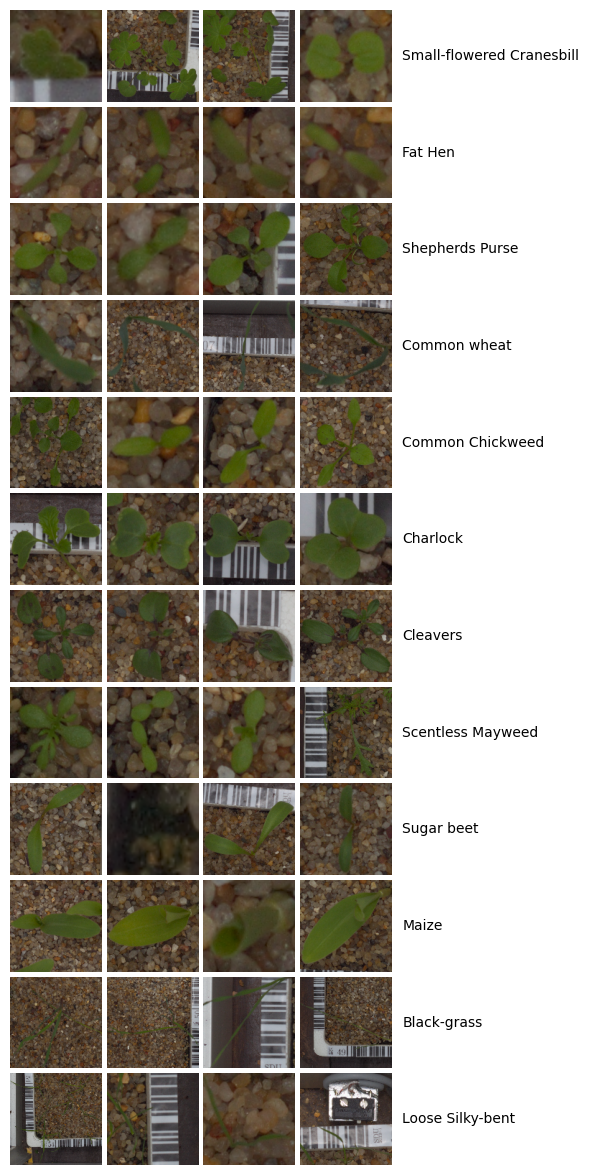

In [17]:
create_image_grid(labels, images, 'Label')

#### Observations
- Several of the image classes show seedling images along with what appears to be a bar code strip.
- Some of the images in classes such as Scentless Mayweed and Loose Silky-bent appear blurry.
- Some of the images show rounded leaves, others are long and narrow, while others show multiple humps in their leaves.
- Black Grass and Loose Silky-bent have extremely slender leaves and are sometimes difficult to see.
- Small-flowered cranesbill images show seedlings that look quite different from each other and could either be mis-labeled or possibly represent seedlings of different maturities.

### Let's look more closely at the class Small-flowered cranesbill

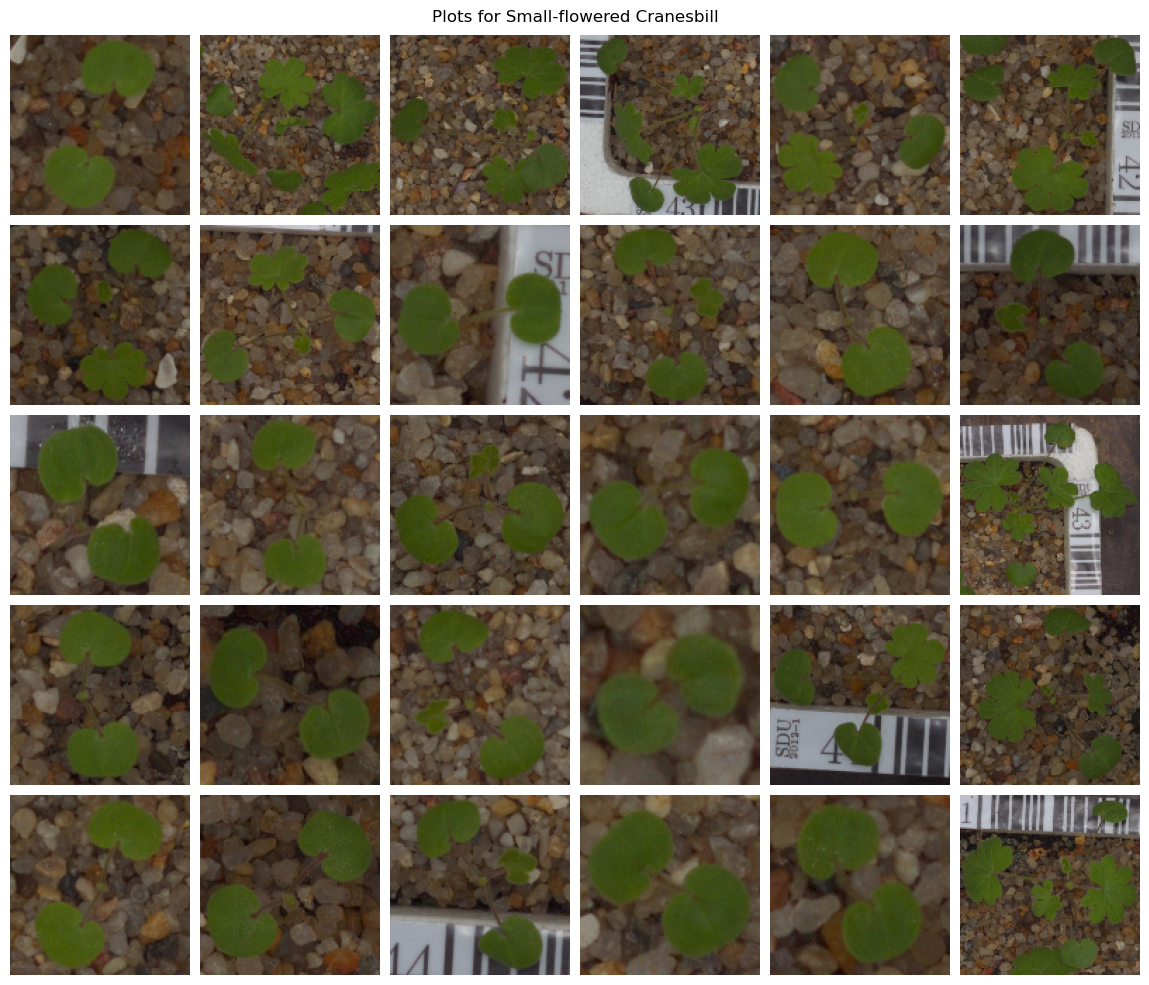

In [18]:
plot_image_class(labels, images, 'Small-flowered Cranesbill')

#### Observations
- We can better see large differences between the Small-flowered Cranesbill images. Some with a rounded leaf and some with several humps.
- This should be investigated to ensure proper labeling since it will likely cause poor predictive capabilities.

### Let's get a sense of the sharpness for the images

In [19]:
# Generate a labeled DataFrame with sharpness levels based on a Laplacian operator
sharpness_df = classify_images(images)
sharpness_df['Seedling'] = labels['Label']

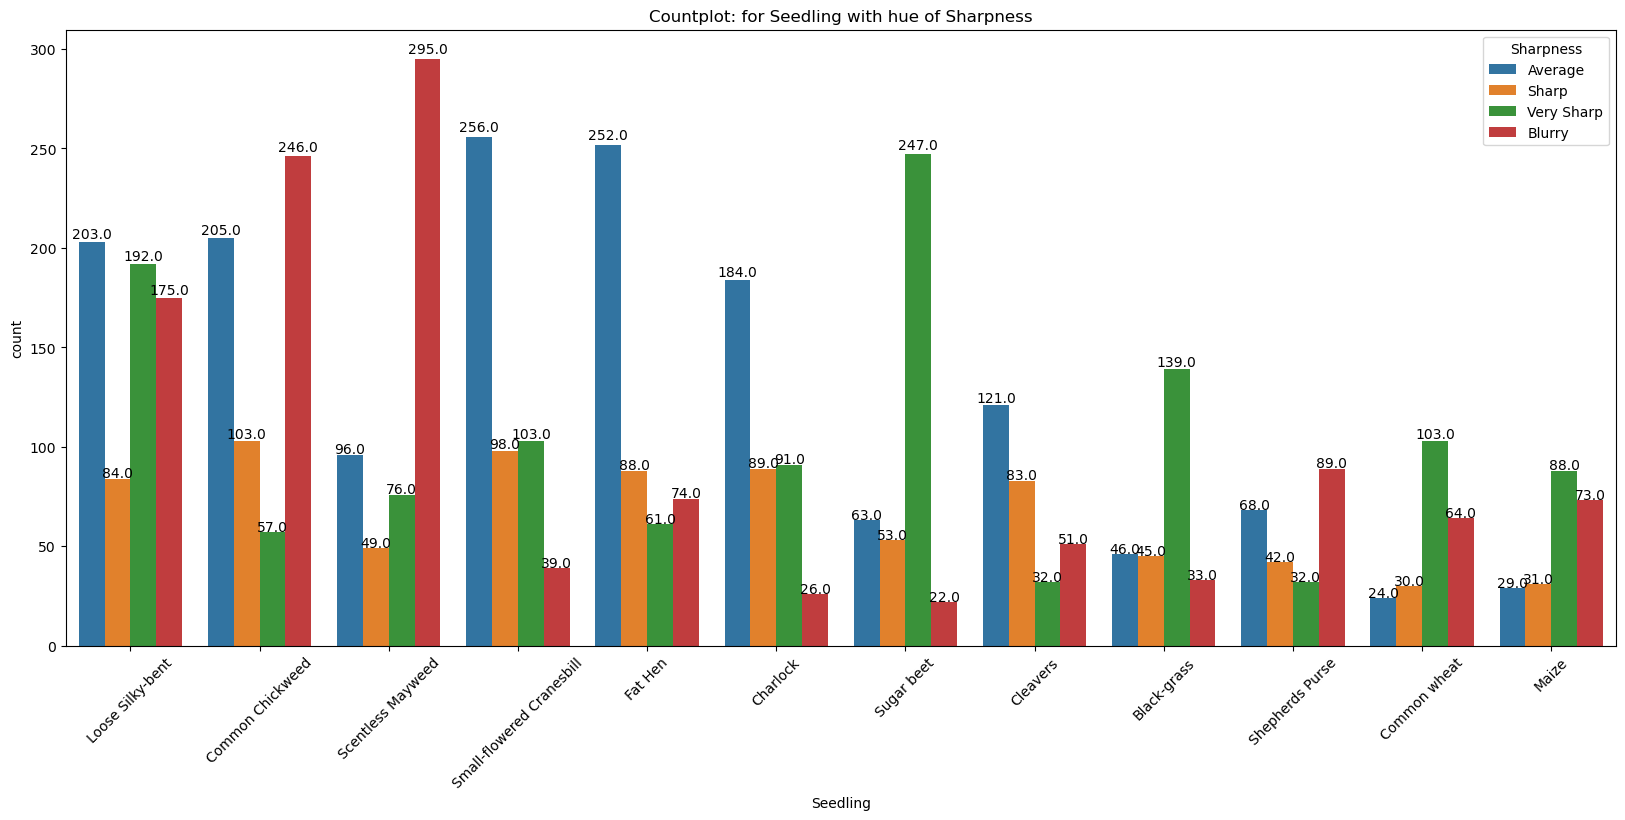

Average       0.325684
Very Sharp    0.257053
Blurry        0.249895
Sharp         0.167368
Name: Sharpness, dtype: float64

In [20]:
# Output a countplot of the sharpness results
output_pretty_countplot(sharpness_df, x='Seedling', hue='Sharpness', \
                        order=sharpness_df['Seedling'].value_counts().index,\
                        figsize=(20, 8))
sharpness_df['Sharpness'].value_counts(normalize=True)

#### Observations
- The top three classes with the largest number of blurry images are Scentless Mayweed, Common Chickweed and Loose Silky-bent.
- According to the assumed sharpness thresholds 24.9% of the images are blurry while the rest are Very Sharp, Average or Sharp.
- Average is the most prominent category with 32.5% of the images while Sharp is the smallest with 16.7% of the images.
- The relatively high level of blurry images could negatively impact the models performance.

### Let's visualize images using the sharpness thresholds

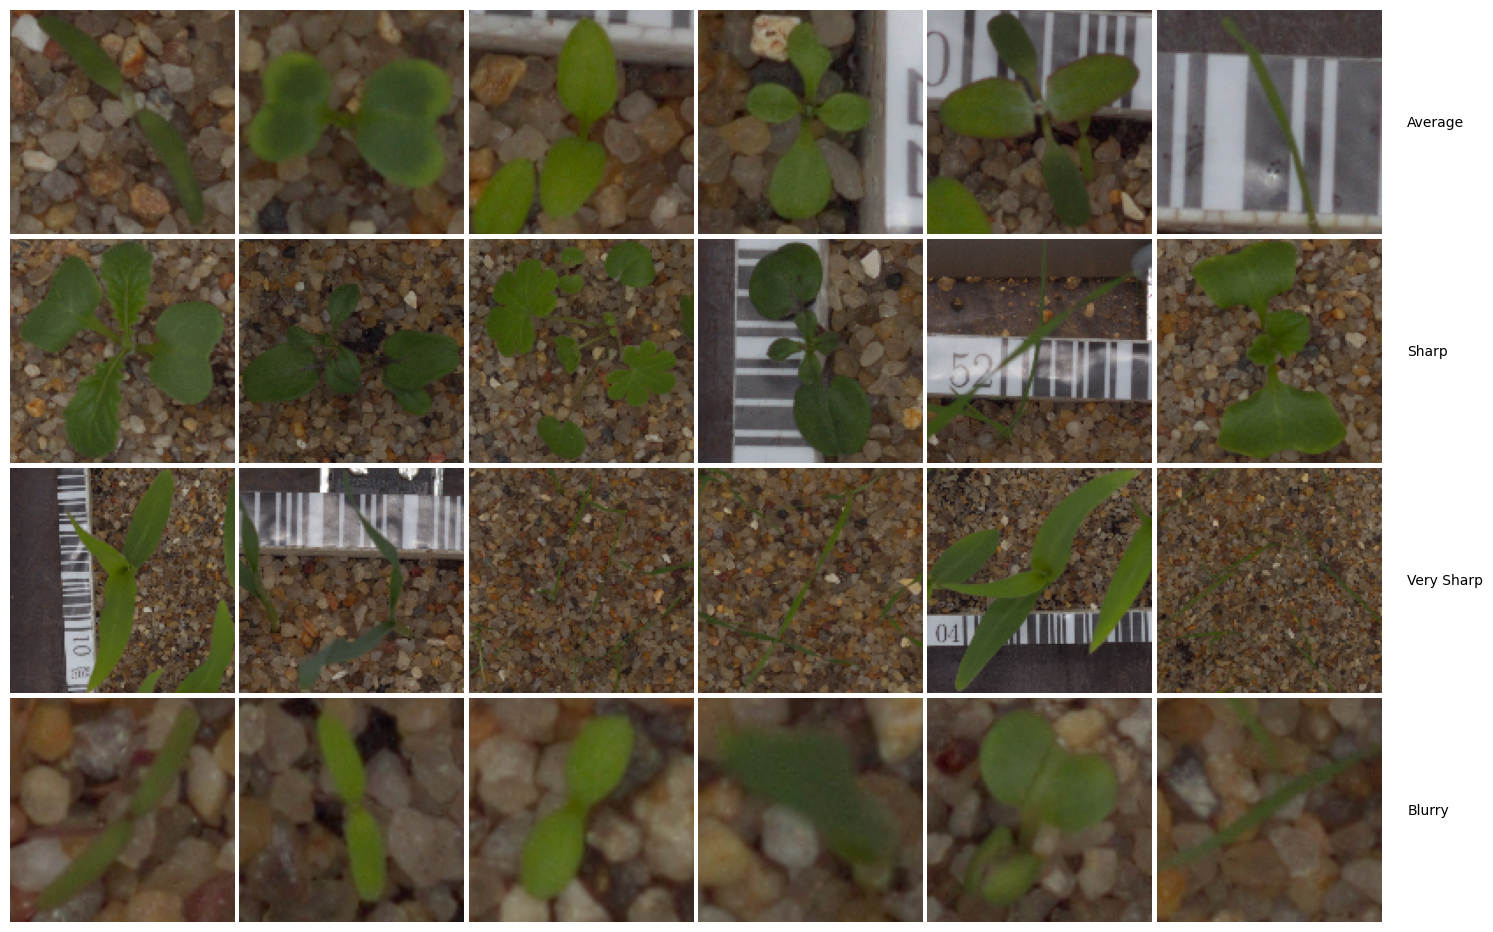

In [21]:
create_image_grid(sharpness_df, images, 'Sharpness', rows=len(sharpness_df['Sharpness'].unique()), columns=6)

### Observations
- The result images by sharpness class look reasonable based on the current sharpness thresholds.
- The Blurry row of images are clearly Blurry in nature.

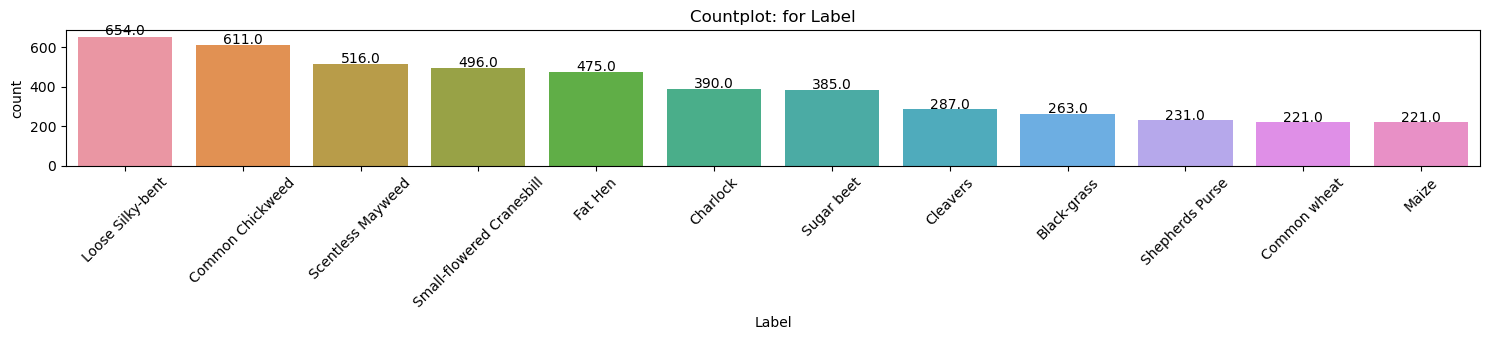

Loose Silky-bent             0.137684
Common Chickweed             0.128632
Scentless Mayweed            0.108632
Small-flowered Cranesbill    0.104421
Fat Hen                      0.100000
Charlock                     0.082105
Sugar beet                   0.081053
Cleavers                     0.060421
Black-grass                  0.055368
Shepherds Purse              0.048632
Common wheat                 0.046526
Maize                        0.046526
Name: Label, dtype: float64

In [22]:
# Output a countplot of the Labels target variable
output_pretty_countplot(labels, 'Label', order=labels['Label'].value_counts().index)
labels['Label'].value_counts(normalize=True)

#### Observations
- As mentioned previously the target variable is imbalanced. The class with the most images is Loose Silky-bent with 13.7% and the classes with the least are Common Wheat and Maize with 4.65%.
- The top four classes Loose Silky-bent, Common Chickweed, Scentless Mayweed and Fat Hen make up 47% of all the images.

## Data Pre-Processing

### Convert the BGR images to RGB and resize images in order to speed the computation

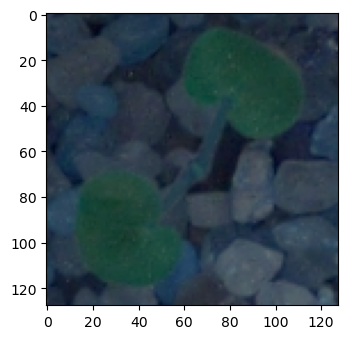

In [23]:
plt.imshow(images[42])

In [24]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV and resize
images_rgb = []
dimensions = (64, 64)
for i in range(len(images)):
  # Convert to rgb and resize source images
  images_rgb.append(cv2.resize(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), dimensions, interpolation=cv2.INTER_AREA))

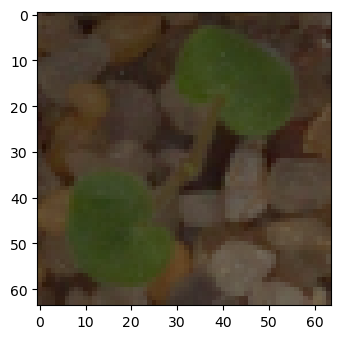

In [25]:
# Same image fter BGR to RGB conversion and resize
plt.imshow(images_rgb[42])

### Observations
- You can see from the updated image that the colors channels are properly rendered and the image is resized.
- The downsampled image does seem a bit pixelated.

In [27]:
np.array(images_rgb).shape

(4750, 64, 64, 3)

### Observations
- There are 4750 images with dimensions 64x64 with three color channels.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [27]:
# Splitting the dataset into the Training and Testing set.
X_train, X_test, y_train, y_test = train_test_split(np.array(images_rgb), labels, test_size=0.1, random_state=seed, stratify=labels,
                                                    shuffle=True)

In [28]:
# Splitting the dataset into the Training and Validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, stratify=y_train,
                                                  shuffle=True)

In [29]:
# Check the shape of train, validation and test data
print('Training:{} {}'.format(X_train.shape,y_train.shape))
print('Validation: {} {}'.format(X_val.shape, y_val.shape))
print('Test: {} {}'.format(X_test.shape,y_test.shape))

Training:(3847, 64, 64, 3) (3847, 1)
Validation: (428, 64, 64, 3) (428, 1)
Test: (475, 64, 64, 3) (475, 1)


### Encode the target labels

In [30]:
# Convert labels from names to one hot vectors.
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [31]:
# Check the shape of train, validation and test data
print('y encoded Training:{}'.format(y_train_encoded.shape))
print('y encoded Validation: {}'.format(y_val_encoded.shape))
print('y encoded Test: {}'.format(y_test_encoded.shape))

y encoded Training:(3847, 12)
y encoded Validation: (428, 12)
y encoded Test: (475, 12)


### Data Normalization
Divide all the pixel values by 255 since their range is 0-255 to create smaller values and minomize exploding gradients and speed computation.

In [32]:
# Complete the code to normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [33]:
# Let's get the list of classes from post LabelBinarizer encoding
unique_encoded = np.flip(np.unique(y_train_encoded, axis=0), axis=0)
categories_decoded = enc.inverse_transform(unique_encoded)
categories_decoded

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [34]:
# Stash the model test performance
testing_results = {}

# Stash the model validation performance
validation_results = {}

# Dictionary of all the models
processed_models = {}

### Build a very basic *CNN*

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

None

Epoch 1/30
121/121 [==============================] - ETA: 0s - loss: 2.1273 - accuracy: 0.2607
Epoch 1: val_accuracy improved from -inf to 0.42991, saving model to seedling_BasicModel
121/121 [==============================] - 14s 20ms/step - loss: 2.1273 - accuracy: 0.2607 - val_loss: 1.6337 - val_accuracy: 0.4299
Epoch 2/30
118/121 [============================>.] - ETA: 0s - loss: 1.5653 - accuracy: 0.4521
Epoch 2: val_accuracy improved from 0.42991 to 0.59346, saving model to seedling_BasicModel
121/121 [==============================] - 2s 15ms/step - loss: 1.5624 - accuracy: 0.4526 - val_loss: 1.3108 - val_accuracy: 0.5935
Epoch 3/30
121/121 [==============================] - ETA: 0s - loss: 1.2244 - accuracy: 0.5776
Epoch 3: val_accuracy improved from 0.59346 to 0.62617, saving model to seedling_BasicModel
121/121 [==============================] - 2s 15ms/step - loss: 1.2244 - accuracy: 0.5776 - val_loss: 1.0959 - val_accuracy: 0.6262
Epoch 4/30
118/121 [======================

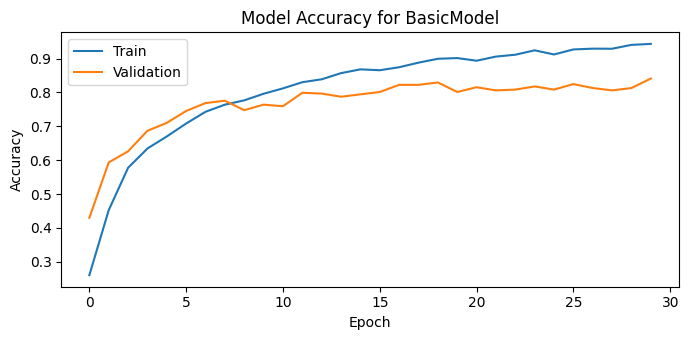

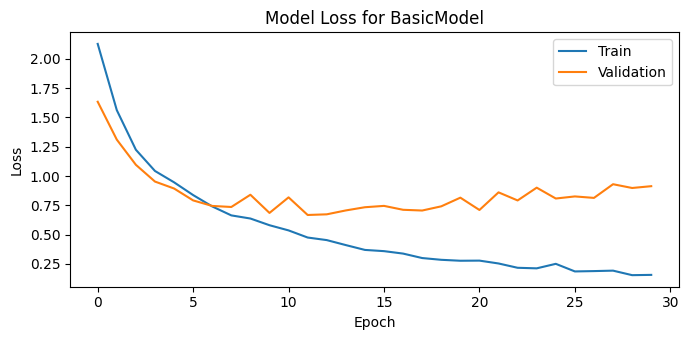

14/14 [==============================] - 0s 3ms/step


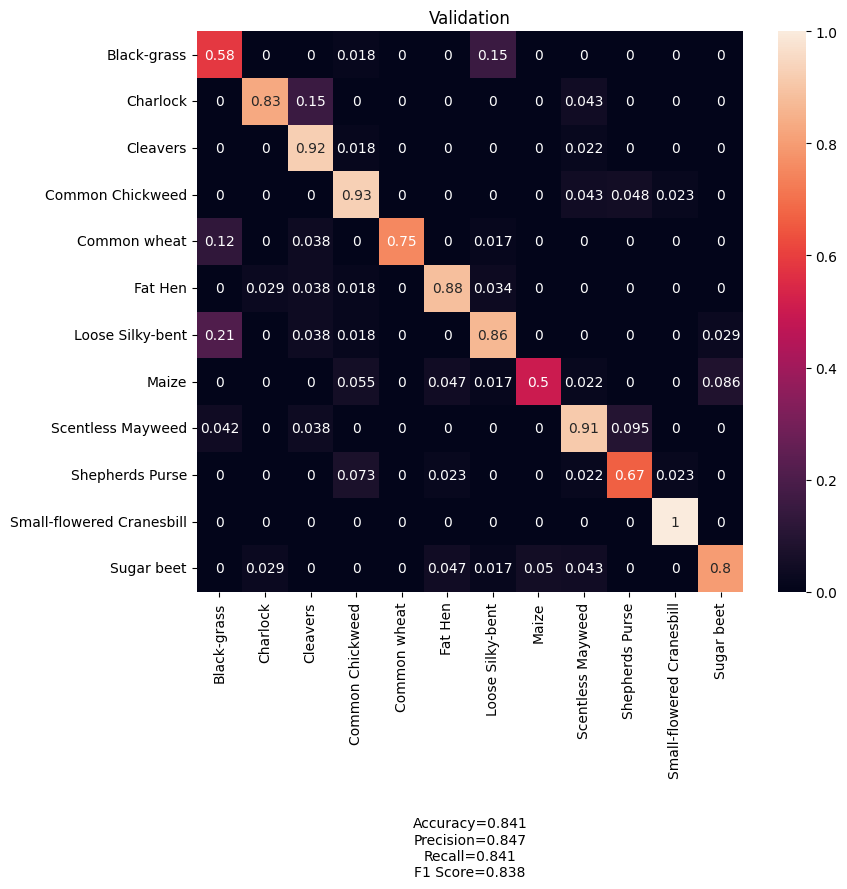

15/15 [==============================] - 0s 13ms/step


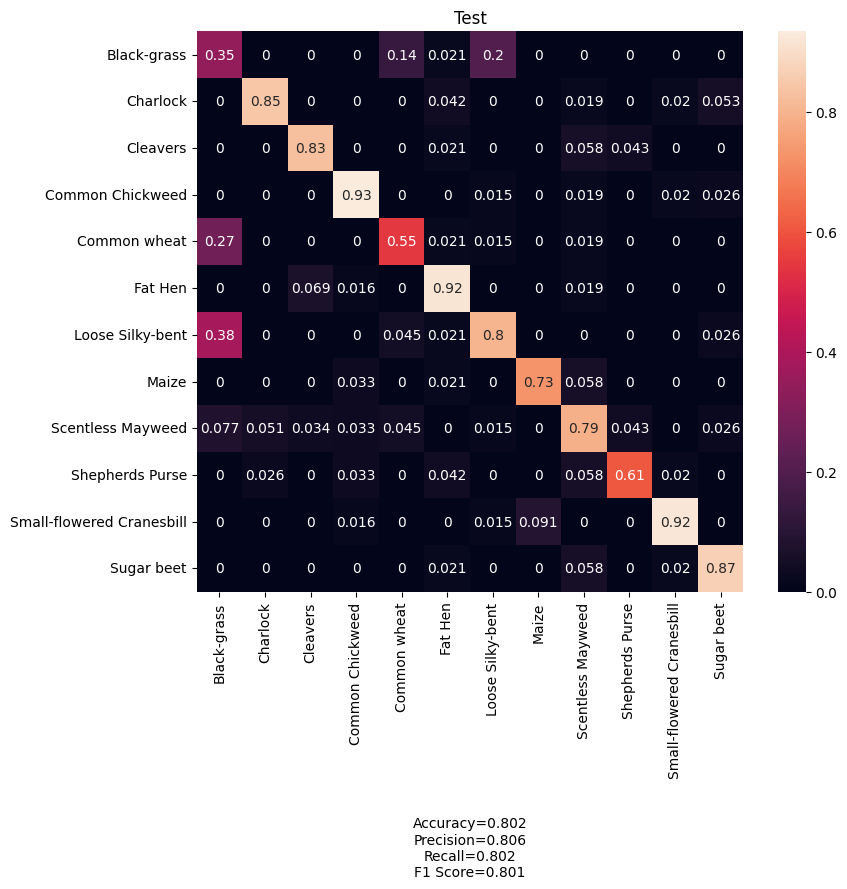

In [35]:
model1 = BasicModel(categories=categories_decoded)
display(model1.model.summary())
model1.build_model(X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, X_test_normalized, y_test_encoded)

In [36]:
# Stash results
testing_results[model1.model_name] = model1.test_results.T
validation_results[model1.model_name] = model1.val_results.T
processed_models[model1.model_name] = model1

#### Observations
- There are 1143500 trainable parameters in the BasicModel.
- We can observe from the loss curve that the validation stops declining around epoch 6 thus this model is overfitting a bit.
- Accuracy for this model for training is 94.34%, validation is 84.1% and testing is 80.2% which is another indication the model is overfitting.
- This model struggled with the True Positive rate for Black Grass (35%) and Shepherds Purse (61%) images on the Test dataset.

## Model Performance Improvement

### Apply Class Weighting

In [37]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=categories_decoded, y=y_train.values.reshape(-1))
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.5050860719874803,
 1: 1.0145042194092826,
 2: 1.3818247126436782,
 3: 0.6476430976430977,
 4: 1.7909683426443204,
 5: 0.8348524305555556,
 6: 0.604874213836478,
 7: 1.7909683426443204,
 8: 0.7669457735247209,
 9: 1.714349376114082,
 10: 0.7974709784411277,
 11: 1.0275106837606838}

### Let's apply class weights to the imbalanced dataset along with BatchNormalization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                        

None

Epoch 1/30
114/121 [===========================>..] - ETA: 0s - loss: 2.0856 - accuracy: 0.2717
Epoch 1: val_accuracy improved from -inf to 0.13785, saving model to seedling_BasicClassWeightsModel
121/121 [==============================] - 6s 20ms/step - loss: 2.0664 - accuracy: 0.2802 - val_loss: 2.4653 - val_accuracy: 0.1379
Epoch 2/30
121/121 [==============================] - ETA: 0s - loss: 1.4713 - accuracy: 0.4689
Epoch 2: val_accuracy improved from 0.13785 to 0.15421, saving model to seedling_BasicClassWeightsModel
121/121 [==============================] - 2s 16ms/step - loss: 1.4713 - accuracy: 0.4689 - val_loss: 2.2950 - val_accuracy: 0.1542
Epoch 3/30
121/121 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.5636
Epoch 3: val_accuracy improved from 0.15421 to 0.41355, saving model to seedling_BasicClassWeightsModel
121/121 [==============================] - 2s 16ms/step - loss: 1.2141 - accuracy: 0.5636 - val_loss: 1.9364 - val_accuracy: 0.4136
Epoch 4

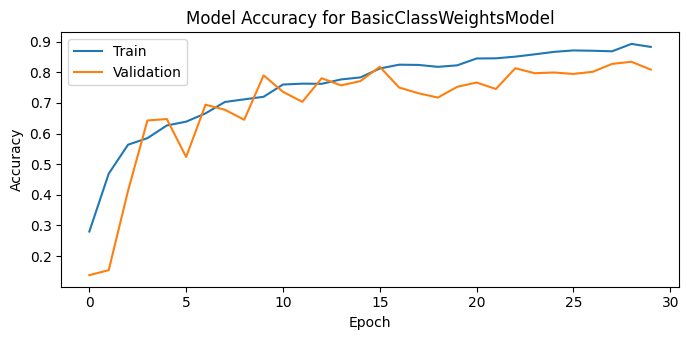

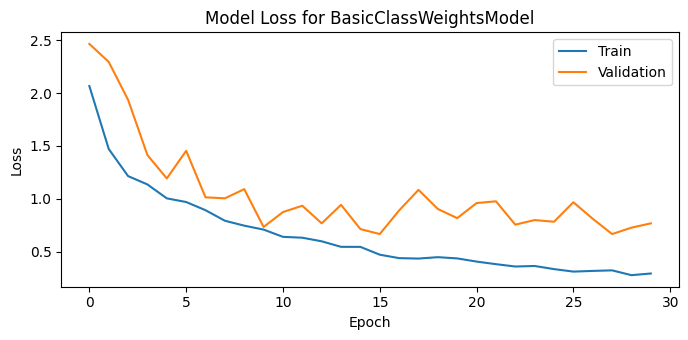

14/14 [==============================] - 0s 3ms/step


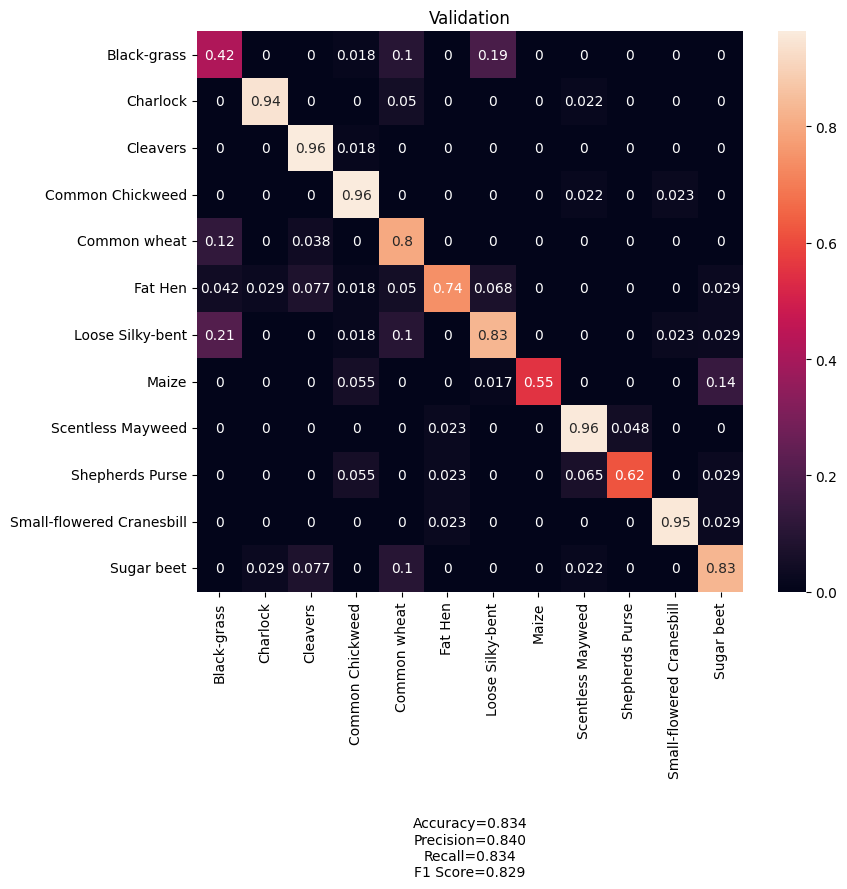

15/15 [==============================] - 0s 3ms/step


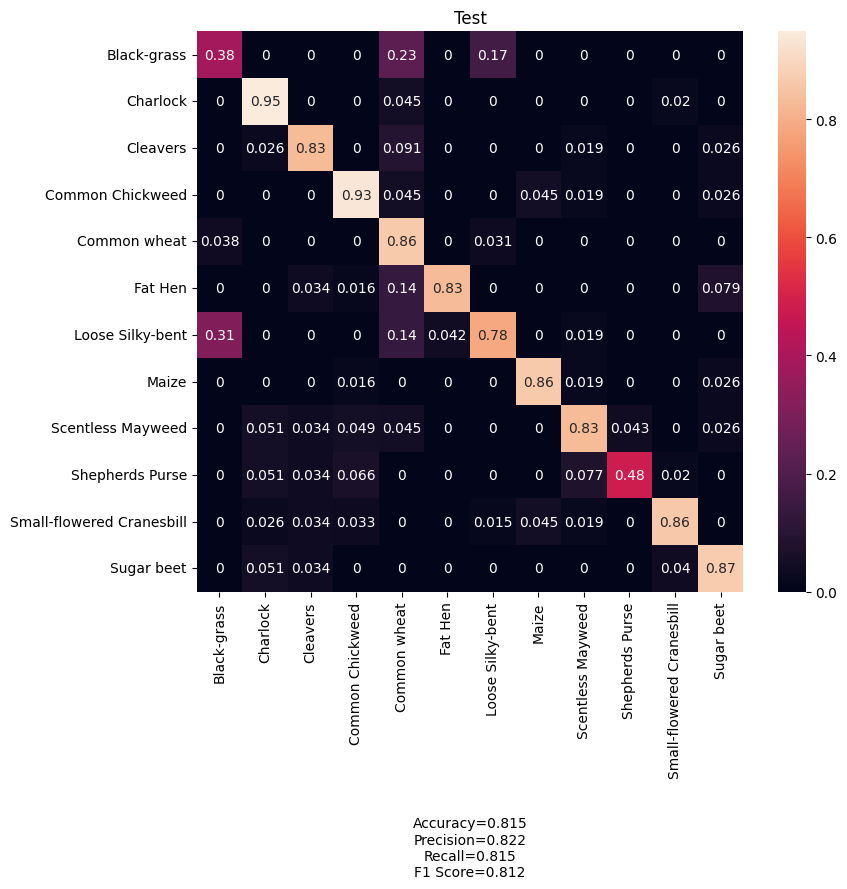

In [38]:
model2 = BasicClassWeightsModel(categories=categories_decoded, class_weights=d_class_weights)
display(model2.model.summary())
model2.build_model(X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, X_test_normalized, y_test_encoded)

In [39]:
# Stash results
testing_results[model2.model_name] = model2.test_results.T
validation_results[model2.model_name] = model2.val_results.T
processed_models[model2.model_name] = model2

#### Observations
- There are 1143628 trainable parameters in the BasicClassWeightsModel.
- Both the loss and accuracy curves for validation are fairly jagged but overall trend in the right direction before epoch 17 when they begin to deviate.
- Accuracy for this model for training is 88.35%, validation is 83.4% and testing is 81.4%. The testing accuracy improved slightly from the previous model.
- Overall the model accuracy improved from the last model even though there is still some overfitting. Overall class weighting and BatchNormalization helped.
- This model also struggled with the True Positive rate for Black Grass (38%) and Shepherds Purse (48%) images on the Test dataset. For this model the True Positive rate for
Black Grass slightly improved.

### Let's try data augmentation for the imbalanced dataset along with BatchNormalization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                        

None

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 1.8510 - accuracy: 0.3842
Epoch 1: val_accuracy improved from -inf to 0.18458, saving model to seedling_BasicTunedModel
121/121 [==============================] - 10s 66ms/step - loss: 1.8510 - accuracy: 0.3842 - val_loss: 2.4480 - val_accuracy: 0.1846 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.5867
Epoch 2: val_accuracy improved from 0.18458 to 0.21262, saving model to seedling_BasicTunedModel
121/121 [==============================] - 6s 53ms/step - loss: 1.2161 - accuracy: 0.5867 - val_loss: 2.3669 - val_accuracy: 0.2126 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.6332
Epoch 3: val_accuracy improved from 0.21262 to 0.38084, saving model to seedling_BasicTunedModel
121/121 [==============================] - 8s 66ms/step - loss: 1.0440 - accuracy: 0.6332 - val_loss: 2.1173 - val_accuracy: 0.3808 -

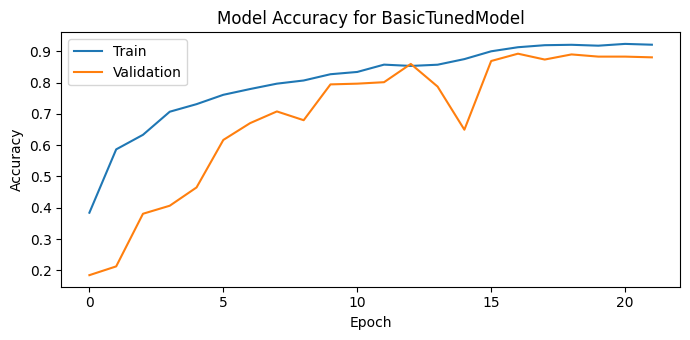

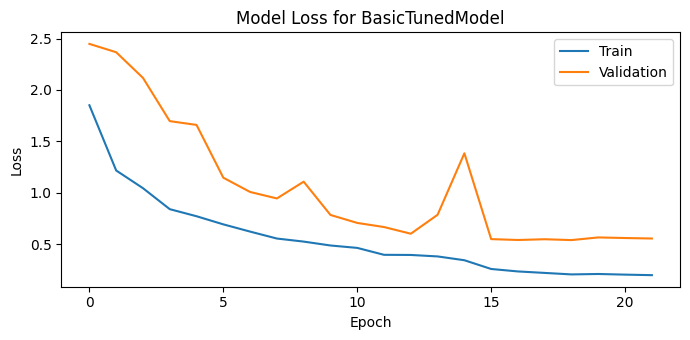

14/14 [==============================] - 0s 3ms/step


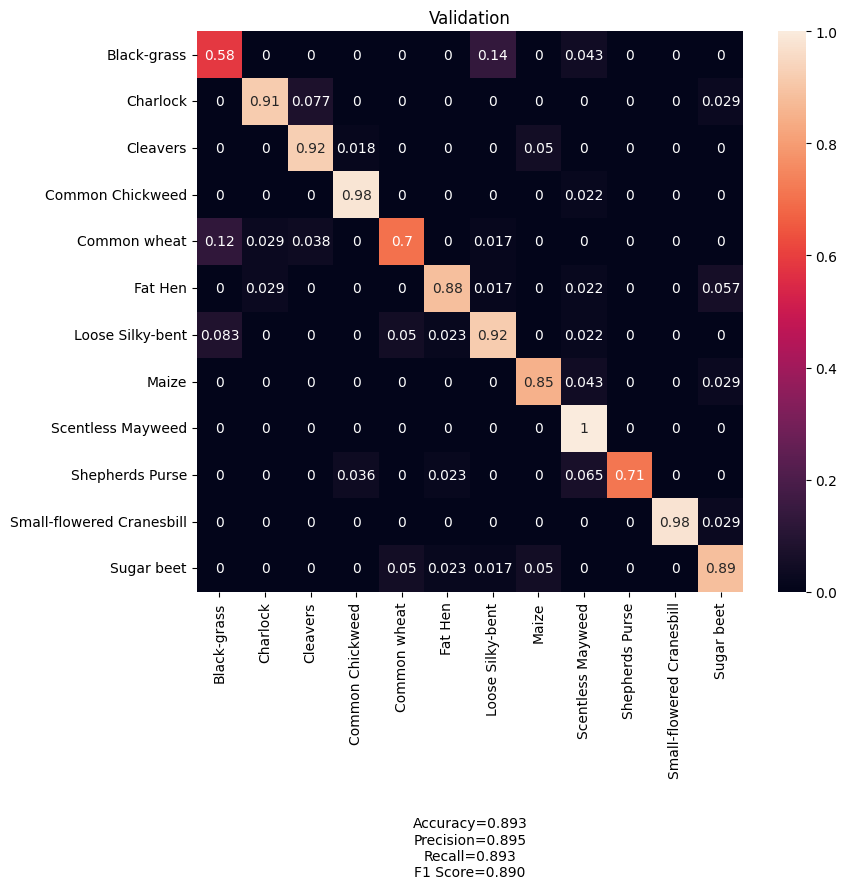

15/15 [==============================] - 0s 3ms/step


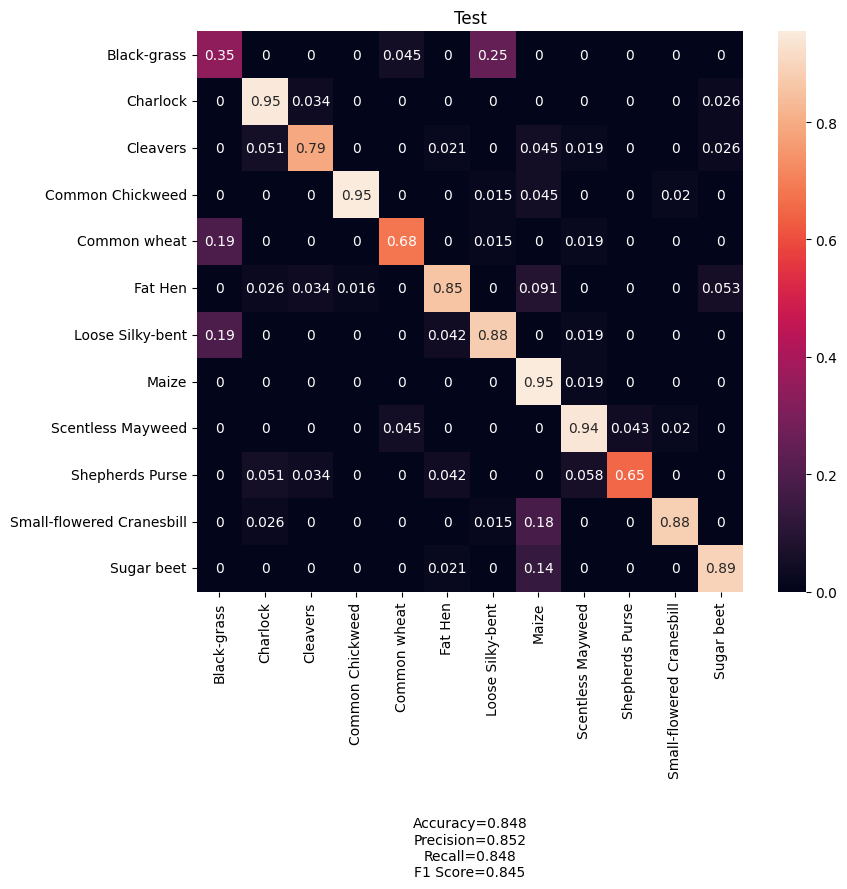

In [40]:
model3 = BasicTunedModel(categories=categories_decoded)
display(model3.model.summary())
model3.build_model(X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, X_test_normalized, y_test_encoded)

In [41]:
# Stash results
testing_results[model3.model_name] = model3.test_results.T
validation_results[model3.model_name] = model3.val_results.T
processed_models[model3.model_name] = model3

#### Observations
- There are 1143628 trainable parameters in the BasicTunedModel.
- Both the loss and accuracy curves smoothed out and validation tracked training much more closely outside of a spike around epoch 14.
- The overall accuracy improved once again due to BatchNormalization, Model tuning, learning rate adjustments and early stopping.
- Accuracy for this model for training is 91.27%, validation is 89.2% and testing is 84.8%.
- This model also struggled with the True Positive rate for Black Grass (35%) and Shepherds Purse (65%) images on the Test dataset. For this model the True Positive rate for
Black Grass declined from the previous model while Shepherds Purse improved.

## Transfer Learning Models
Transfer learning with pre-trained models involves utilizing a pre-trained neural network, initially developed for one task or dataset, as a foundation for solving a different but related task. By leveraging the learned features and representations from the pre-trained model, this approach enables the efficient adaptation of the model to new tasks with potentially limited data. The lower layers of the pre-trained model capture general features applicable to various tasks, while the higher layers, which are task-specific, can be fine-tuned or replaced to suit the new problem, thus accelerating training and often improving performance.

In [42]:
def resize_for_transfer_model(x):
  # Converting the images to 299x299 which is the default image size for InceptionV3
  images_processed = []
  dimensions = (299, 299)
  for i in range(len(x)):
    # Resize source images
    images_processed.append(cv2.resize(x[i], dimensions, interpolation=cv2.INTER_LINEAR))

  return np.array(images_processed)

In [43]:
# Resize all the normalized datasets to 299x299 which is the default input size for InceptionV3
X_train_299 = resize_for_transfer_model(X_train_normalized)
X_val_299 = resize_for_transfer_model(X_val_normalized)
X_test_299 = resize_for_transfer_model(X_test_normalized)

In [44]:
# Check the shape of train, validation and test data
print('Transfer Training:{} {}'.format(X_train_299.shape,y_train_encoded.shape))
print('Transfer Validation: {} {}'.format(X_val_299.shape, y_val_encoded.shape))
print('Transfer Test: {} {}'.format(X_test_299.shape,y_test_encoded.shape))

Transfer Training:(3847, 299, 299, 3) (3847, 12)
Transfer Validation: (428, 299, 299, 3) (428, 12)
Transfer Test: (475, 299, 299, 3) (475, 12)


### Inception Model
https://keras.io/api/applications/inceptionv3/ we are choosing to use only part of the full convolution layers since seedling images are not very complex in nature and to speed computation and minimize model complexity.

96112376/96112376 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 17, 17, 768)       5138656   
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 12)                30

None

Training InceptionModel...
Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 1.9317 - accuracy: 0.3514
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to seedling_InceptionModel
121/121 [==============================] - 110s 856ms/step - loss: 1.9317 - accuracy: 0.3514 - val_loss: 1.4028 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 1.2334 - accuracy: 0.5750
Epoch 2: val_accuracy improved from 0.50000 to 0.65421, saving model to seedling_InceptionModel
121/121 [==============================] - 98s 815ms/step - loss: 1.2334 - accuracy: 0.5750 - val_loss: 1.0126 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.6649
Epoch 3: val_accuracy improved from 0.65421 to 0.72430, saving model to seedling_InceptionModel
121/121 [==============================] - 99s 822ms/step - loss: 0.9442 - accuracy: 0.6649 - val_loss: 0

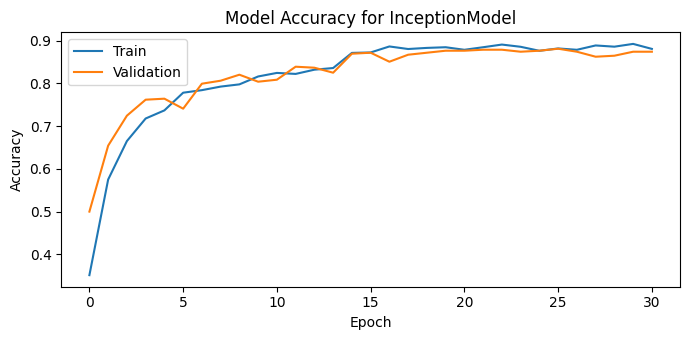

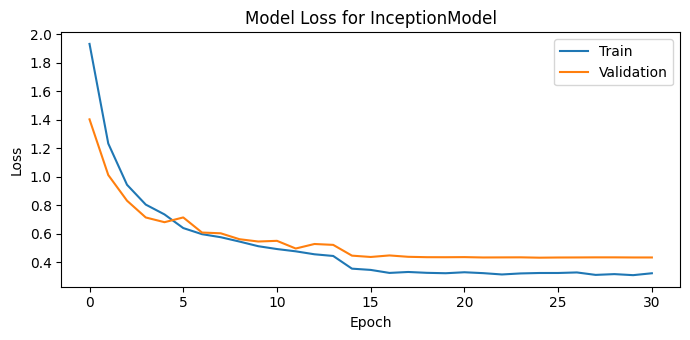

14/14 [==============================] - 2s 78ms/step


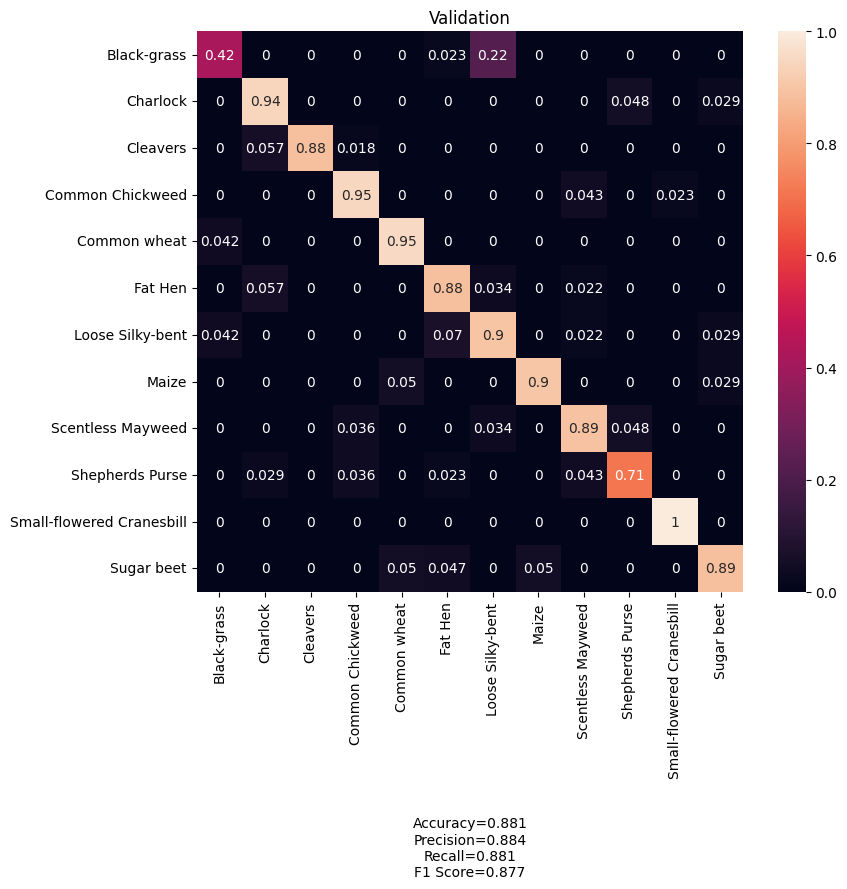

15/15 [==============================] - 3s 230ms/step


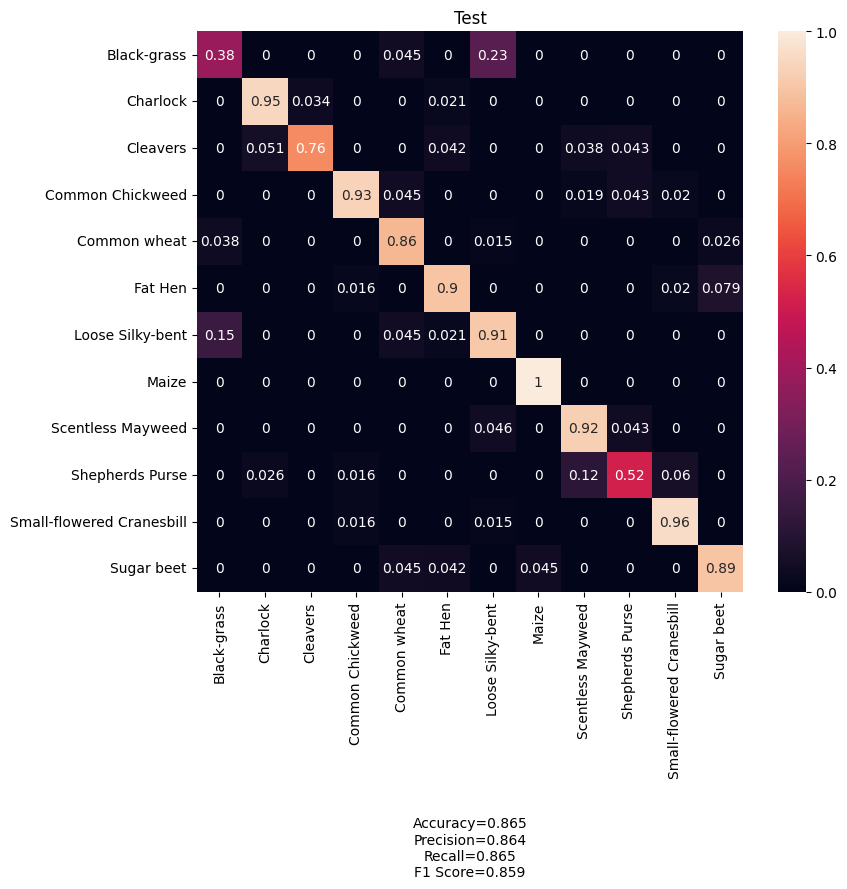

In [45]:
model4 = InceptionModel(categories=categories_decoded)
display(model4.model.summary())
model4.build_transfer_model(X_train_299, y_train_encoded, X_val_299, y_val_encoded, X_test_299, y_test_encoded)

In [46]:
# Stash results
testing_results[model4.model_name] = model4.test_results.T
validation_results[model4.model_name] = model4.val_results.T
processed_models[model4.model_name] = model4

#### Observations
- There are 265740 trainable parameters in the InceptionModel which is a fraction of the parameters compared to the previous models.
- Both the loss and accuracy curves are very smooth and validation tracks training very closely.
- The overall accuracy improved once again due to Transfer model, Model tuning, learning rate adjustments and early stopping.
- Accuracy for this model for training is 88.15%, validation is 88.08% and testing is 86.5%. All three of these metrics are extremely close confirming the models generalizability.
- This model also struggled with the True Positive rate for Black Grass (38%) and Shepherds Purse (52%).

## Final Results

In [47]:
# validation performance comparison
models_val_comp_df = get_performance_results(validation_results, 'Validation')
models_val_comp_df

In [48]:
# testing performance comparison
models_testing_comp_df = get_performance_results(testing_results, 'Test')
models_testing_comp_df

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

- Based on the analysis the InceptionModel is the most generalizable and has the highest accuracy for Test.

### Visualizing the prediction

In [49]:
best_model = processed_models['InceptionModel']

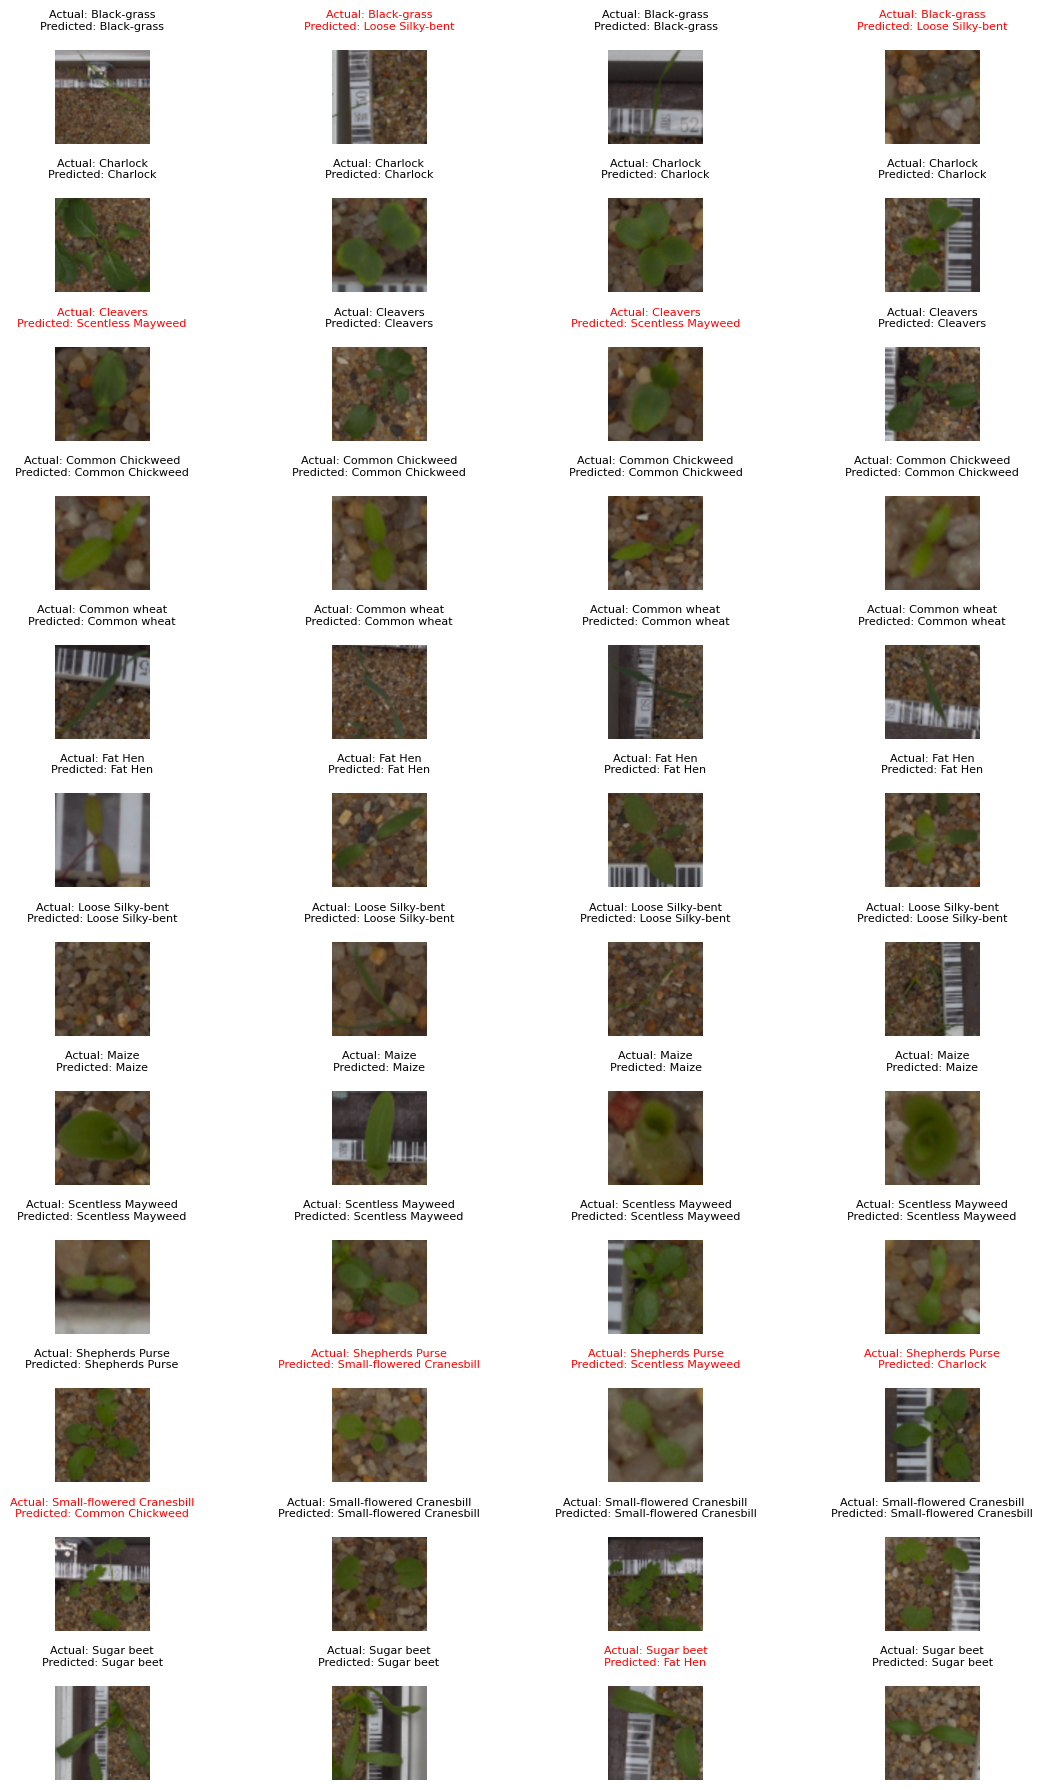

In [52]:
# Plot randomly selected images using the best model from the test dataset predictions
plot_predicted_images(X_test_299, y_test_encoded, best_model.y_pred_test, categories_decoded, num_samples=4)

### Observations
- As shown above all models struggled with Black Grass and Shepherds Purse.

## Actionable Insights and Business Recommendations

* The top performing model is the InceptionModel based on Transfer Learning with a training accuracy of 88.15%, validation accuracy of 88.08% and testing accuracy of 86.5%. All three of these metrics are extremely close confirming the models generalizability.
* Overall this model did extremely well with its predictive accuracy but like other models the two types of seedlings it struggles are Black Grass and Shepherds Purse.
* There is a high level of blurriness with the images (24.9%) which can have a negative impact on model performance. If images can be improved this analysis should be rerun and will likely have even better model performance.
* The image labeling should be double checked for veracity. Visually the Small-flowered Cranesbill appears to either have different maturities of seedlings (which appear quite different) or potentially the class is mislabelled which can also negatively impact model performance. If this potential issue can be resolved model performance will likely increase.

### Data Insights
* The class with the most images is Loose Silky-bent with 13.7% and the classes with the least are Common Wheat and Maize with 4.65%.
* The top four classes Loose Silky-bent, Common Chickweed, Scentless Mayweed and Fat Hen make up 47% of all the images. This imbalance was dealt with using class-weighting and data augmentation.
* Black Grass has a high level of blurry shots and its leaves are extremely slender and hard to see.
* The top three classes with the largest number of blurry images are Scentless Mayweed, Common Chickweed and Loose Silky-bent.

#### Further analysis that can be done:
* Rerun with Inception model and directly re-size/recolor from the source 128x128 images. I attempted this rather than resizing to 64x64 then to 299x299 but ran out of RAM on google colab.
* Rerun with additional Transfer Learning models. I tried VGG19, XCeption and Inception and Inception performed the best.
* Research how blurry images could be corrected programmatically. I tried to do selective sharpening of the dataset using a Laplacian operator to detect blurriness. The resulting accuracy was in the 40% range but I suspect could be improved with other convolution filters and additional tuning.

_____